# Figure 3: Oscillations must not cross fitting range borders

In [1]:
import warnings
from pathlib import Path

import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import mne
import numpy as np
import scipy.signal as sig
import yaml
from fooof import FOOOF
from fooof.sim.gen import gen_aperiodic
from scipy.stats import pearsonr

from utils import elec_phys_signal

#### Load params and make directory

In [2]:
yaml_file = open('params.yml')
parsed_yaml_file = yaml.load(yaml_file, Loader=yaml.FullLoader)
globals().update(parsed_yaml_file)

Path(fig_path).mkdir(parents=True, exist_ok=True)

#### a) Simulate signal with three oscillations and fit

In [3]:
# Signal params
sample_rate = 2400
nperseg = sample_rate
welch_params = dict(fs=sample_rate, nperseg=nperseg)

# fit in all frequency ranges from 1 to 80...
lower_fitting_borders = range(1, 80)
# ... to 100 Hz
upper_fitting_border = 100

# Oscillations parameters:
sim_exponent = 2
freq1, freq2, freq3 = 5, 15, 35  # Hz
amp1, amp2, amp3 = .4, .1, .02
width = .01

periodic_params = [(freq1, amp1, width),
                   (freq2, amp2, width),
                   (freq3, amp3, width)]

# Sim Toy Signal
_, full_signal = elec_phys_signal(sim_exponent,
                                  periodic_params=periodic_params)
freq_a, full_psd = sig.welch(full_signal, **welch_params)

# Filter 1-100Hz
filt = (freq_a <= 100)
freq_a = freq_a[filt]
full_psd = full_psd[filt]

# Fit fooof and subtract ground truth to obtain fitting error
fit_errors = []
fm = FOOOF(verbose=None)
for low in lower_fitting_borders:
    freq_range = (low, upper_fitting_border)
    fm.fit(freq_a, full_psd, freq_range)
    exp = fm.get_params("aperiodic", "exponent")
    error = np.abs(sim_exponent - exp)
    fit_errors.append(error)

error_plot = (lower_fitting_borders, fit_errors, c_error)

#### b) Load real data and fit fooof different freq ranges

In [4]:
# Load data
data_path = "../data/Fig3/"
fname10 = "subj10_on_R8_raw.fif"

sub10 = mne.io.read_raw_fif(data_path + fname10, preload=True)
sub10.pick_channels(["STN_L23"])

# Notch Filter
filter_params = {"freqs": np.arange(50, 601, 50),
                 "notch_widths": .5,
                 "method": "spectrum_fit"}
sub10.notch_filter(**filter_params)

# Convert to numpy and calc PSD
start = int(0.5*sample_rate)  # artefacts in beginning and end
stop = int(185*sample_rate)
sub10 = sub10.get_data(start=start, stop=stop)[0]
freq, spec10 = sig.welch(sub10, **welch_params)

# Filter above highpass and below lowpass
filt = (freq <= 600)
freq = freq[filt]
spec10 = spec10[filt]

plot_psd_spec10 = (freq, spec10, c_real)

# Set common 1/f fitting ranges
frange1 = (1, 95)
frange2 = (30, 45)
frange3 = (40, 60)
frange4 = (1, 45)

# Set corresponding fooof fitting parameters
peak_width_limits = (1, 100)  # huge beta peak spans from 10 to almost 100 Hz
max_n_peaks = 0  # some fitting ranges try to avoid oscillations peaks
fooof_params1 = dict(peak_width_limits=peak_width_limits, verbose=False)
fooof_params2 = dict(max_n_peaks=max_n_peaks, verbose=False)
fooof_params3 = dict(max_n_peaks=max_n_peaks, verbose=False)
fooof_params4 = dict(peak_width_limits=peak_width_limits, verbose=False)

# Combine
fit_params = [(frange1, fooof_params1, c_fit_fooof1),
              (frange2, fooof_params2, c_fit_fooof2),
              (frange3, fooof_params3, c_fit_fooof3),
              (frange4, fooof_params4, c_fit_fooof4)]

# Fit for different ranges
fit_ranges = []
fooof_fits = []
dotted = True
for frange, fooof_params, plot_color in fit_params:
    # fit
    fm = FOOOF(**fooof_params)
    fm.fit(freq, spec10, frange)
    fooof_fits.append(fm)
    ap_fit = gen_aperiodic(fm.freqs, fm.aperiodic_params_)
    plot_args = (fm.freqs, 10**ap_fit, plot_color)

    # set plot labels
    freq_low, freq_up = frange
    freq_str = f"{freq_low}-{freq_up}Hz"
    if freq_low == 1:  # add extra spaces if freq_low=1 for aligned legend
        freq_str = "  " + freq_str
    exp = fm.get_params("aperiodic", "exponent")
    plot_label = freq_str + rf" $\beta$={exp:.2f}"
    if dotted:  # set linestyle
        ls = ":"
        dotted = False
    else:
        ls = "-"
    plot_kwargs = dict(lw=2, ls=ls, label=plot_label)

    # append plot argument (tuple) and plot_kwargs (dict) as tuple
    fit_ranges.append((plot_args, plot_kwargs))

Opening raw data file ../data/Fig3/subj10_on_R8_raw.fif...
Isotrak not found
    Range : 0 ... 719999 =      0.000 ...   300.000 secs
Ready.
Reading 0 ... 719999  =      0.000 ...   300.000 secs...
Removed notch frequencies (Hz):
     50.00 :   59 windows
    100.00 :   59 windows
    150.00 :   59 windows
    200.00 :   59 windows
    250.00 :   59 windows
    300.00 :   59 windows
    350.00 :   59 windows
    400.00 :   59 windows
    450.00 :   59 windows
    500.00 :   59 windows
    550.00 :   59 windows
    600.00 :   59 windows


#### c) Simulate PSD to reproduce real PSD from b)

In [5]:
exponent = 1.5  # 1/f exponent
nlv = 0.0003  # white noise level

# Oscillations as tuple (frequency, amplitude, width)
alpha = (12, 1.7, 3)
low_beta = (18, 2, 2)
high_beta = (27, 20, 6)
gamma = (50, 6, 15)
hfo = (360, 20, 60)

oscillations = (alpha, low_beta, high_beta, gamma, hfo)

# Delta oscillations
delta_freq = 2
delta_width = 6
delta_amp1, delta_amp2, delta_amp3 = 0, 1.9, 3.8
low_delta = (delta_freq, delta_amp1, delta_width)
med_delta = (delta_freq, delta_amp2, delta_width)
high_delta = (delta_freq, delta_amp3, delta_width)

osc_params_low = [low_delta, *oscillations]
osc_params_med = [med_delta, *oscillations]
osc_params_high = [high_delta, *oscillations]

# Make signals
elec_params = dict(exponent=exponent, nlv=nlv, highpass=True)

aperiodic, full_low = elec_phys_signal(periodic_params=osc_params_low,
                                       **elec_params)
aperiodic, full_med = elec_phys_signal(periodic_params=osc_params_med,
                                       **elec_params)
aperiodic, full_high = elec_phys_signal(periodic_params=osc_params_high,
                                        **elec_params)

# Calc PSD
freq, psd_aperiodic = sig.welch(aperiodic, **welch_params)
freq, psd_low = sig.welch(full_low, **welch_params)
freq, psd_med = sig.welch(full_med, **welch_params)
freq, psd_high = sig.welch(full_high, **welch_params)

# Bandpass filter between 1Hz and 600Hz
freq = freq[filt]
psd_aperiodic = psd_aperiodic[filt]
psd_low = psd_low[filt]
psd_med = psd_med[filt]
psd_high = psd_high[filt]

# Normalize spectra to bring together real and simulated PSD.
# We cannot use the 1Hz offset because we want to show the impact of Delta
# oscillations -> so we normalize at the plateau by taking the median
# (to avoid notch filter outliers) and divide
plateau = (freq > 105) & (freq < 195)

spec10_adj = spec10 / np.median(spec10[plateau])
psd_aperiodic /= np.median(psd_aperiodic[plateau])
psd_low /= np.median(psd_low[plateau])
psd_med /= np.median(psd_med[plateau])
psd_high /= np.median(psd_high[plateau])

# Pack lines for plotting
plot_psd_spec10_adj = (freq, spec10_adj)
plot_psd_low = (freq, psd_low, c_low)
plot_psd_med = (freq, psd_med, c_med)
plot_psd_high = (freq, psd_high, c_high)

# Summarize
psd_delta_vary = [plot_psd_low, plot_psd_med, plot_psd_high]

# Plot delta power
delta_mask = (freq <= 4)

freq_delta = freq[delta_mask]
psd_aperiodic_delta = psd_aperiodic[delta_mask]
psd_low_delta = psd_low[delta_mask]
psd_med_delta = psd_med[delta_mask]
psd_high_delta = psd_high[delta_mask]

plot_delta_low = (freq_delta, psd_low_delta, psd_aperiodic_delta)
plot_delta_med = (freq_delta, psd_med_delta, psd_aperiodic_delta)
plot_delta_high = (freq_delta, psd_high_delta, psd_aperiodic_delta)

# Summarize
delta_power = [plot_delta_low, plot_delta_med, plot_delta_high]

# Fit real and simulated spectra
fm_LFP = FOOOF(**fooof_params1)
fm_low = FOOOF(**fooof_params1)
fm_med = FOOOF(**fooof_params1)
fm_high = FOOOF(**fooof_params1)

fm_LFP.fit(freq, spec10_adj, frange1)
fm_low.fit(freq, psd_low, frange1)
fm_med.fit(freq, psd_med, frange1)
fm_high.fit(freq, psd_high, frange1)

exp_LFP = fm_LFP.get_params('aperiodic_params', 'exponent')
exp_low = fm_low.get_params('aperiodic_params', 'exponent')
exp_med = fm_med.get_params('aperiodic_params', 'exponent')
exp_high = fm_high.get_params('aperiodic_params', 'exponent')

# Summarize
exponents = [("low", exp_low), ("med", exp_med), ("high", exp_high)]
delta_labels = [fr"fooof {pwr} delta $\beta$={exp:.2f}"
                for pwr, exp in exponents]

ap_fit_LFP = gen_aperiodic(fm_LFP.freqs, fm_LFP.aperiodic_params_)
ap_fit_low = gen_aperiodic(fm_low.freqs, fm_low.aperiodic_params_)
ap_fit_med = gen_aperiodic(fm_med.freqs, fm_med.aperiodic_params_)
ap_fit_high = gen_aperiodic(fm_high.freqs, fm_high.aperiodic_params_)

# Pack lines for plotting
plot_fit_spec10 = (fm_LFP.freqs, 10**ap_fit_LFP, ":")
plot_aperiodic = (freq, psd_aperiodic, c_ground)
plot_fit_low = (fm_low.freqs, 10**ap_fit_low, "--")
plot_fit_med = (fm_med.freqs, 10**ap_fit_med, "--")
plot_fit_high = (fm_high.freqs, 10**ap_fit_high, "--")

# Summarize
psd_delta_fits = [plot_fit_low, plot_fit_med, plot_fit_high]

spec10_kwargs = dict(c=c_real, lw=2)
aperiodic_kwargs = dict(lw=.5)
low_kwargs = dict(c=c_low, lw=2)
med_kwargs = dict(c=c_med, lw=2)
high_kwargs = dict(c=c_high, lw=2)

# Summarize
delta_kwargs = [low_kwargs, med_kwargs, high_kwargs]
colors_c = [c_low, c_med, c_high]

#### Plot settings

In [19]:
# mpl settings
mpl.rcParams['xtick.labelsize'] = legend_fontsize
mpl.rcParams['ytick.labelsize'] = legend_fontsize
mpl.rcParams['axes.labelsize'] = legend_fontsize
mpl.rcParams['legend.fontsize'] = legend_fontsize
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["font.size"] = 14

abc = dict(x=0, y=1.04, fontsize=panel_fontsize,
           fontdict=dict(fontweight="bold"))

# a)
# a1
ymini = -13
ymaxi = -7
yticks_a1 = 10**np.arange(ymini, ymaxi, dtype=float)
ylim_a1 = (yticks_a1[0], yticks_a1[-1])
yticklabels_a1 = [""] * len(yticks_a1)
yticklabels_a1[0] = fr"$10^{{{ymini}}}$"
yticklabels_a1[-1] = fr"$10^{{{ymaxi}}}$"
ylabel_a1 = "PSD [a.u.]"

xlabel_a1 = "Frequency [Hz]"
xticklabels_a1 = []
xlim_a = (1, 100)
axes_a1 = dict(xticklabels=xticklabels_a1, yticks=yticks_a1, ylim=ylim_a1,
               yticklabels=yticklabels_a1, xlim=xlim_a, xlabel=xlabel_a1)
freqs123 = [freq1, freq2, freq3]
colors123 = [c_range1, c_range2, c_range3]
text_dic = dict(x=100, ha="right", fontsize=legend_fontsize)

# a2
xticks_a2 = [1, 10, 100]
yticks_a2 = [0, .5, 1]
xlabel_a2 = "Lower fitting range border [Hz]"
ylabel_a2 = r"$|\beta_{truth} - \beta_{fooof}|$"
ylim_a2 = (0, 1)
axes_a2 = dict(xticks=xticks_a2, xticklabels=xticks_a2, yticks=yticks_a2,
               xlim=xlim_a, xlabel=xlabel_a2, ylim=ylim_a2)

# b)
xticks_b = [1, 10, 100, 600]
xlim_b = (1, 826)
xlabel_b = "Frequency [Hz]"
ylabel_b = r"PSD [$\mu$$V^2$/Hz]"
axes_b = dict(xlabel=xlabel_b, xticks=xticks_b, xticklabels=xticks_b,
              # yticks=yticks_b, yticklabels=yticklabels_b,
              xlim=xlim_b, ylabel=ylabel_b)

# c)
ylabel_c = "PSD [a.u.]"
axes_c = dict(xticks=xticks_b, xticklabels=xticks_b,
              yticks=[])
x_label_c2 = f"Fitting range: {frange1[0]}-{frange1[1]} Hz"
leg_c = dict(ncol=3, loc=10, bbox_to_anchor=(.5, .35))
delta_fill_dic = dict(alpha=0.4)

# Annotate increased/decreased delta power with arrows
x_arrow = 0.9  # set arrow slightly below 1Hz
spec10_fit_offset = 10**ap_fit_LFP[0]  # LFP power at 1Hz
low_fit_offset = 10**ap_fit_low[0]  # sim_low power at 1Hz
high_fit_offset = 10**ap_fit_high[0]  # sim_high power at 1Hz

# Arrow coordinates. Up-scale to account for x_arrow < 1 Hz
arr_head_low = (x_arrow, low_fit_offset * 0.95)
arr_tail_low = (x_arrow, spec10_fit_offset * 1.1)

arr_head_high = (x_arrow, high_fit_offset * 1.1)
arr_tail_high = (x_arrow, spec10_fit_offset * 1)

# Arrow style
arrowstyle = "->, head_length=0.2,head_width=0.2"
arrow_dic = dict(arrowprops=dict(arrowstyle=arrowstyle, lw=2))

# Arrow dic
arr_pos_low = dict(text="", xy=arr_head_low, xytext=arr_tail_low,
                   **arrow_dic)
arr_pos_high = dict(text="", xy=arr_head_high, xytext=arr_tail_high,
                    **arrow_dic)

# Figure 3

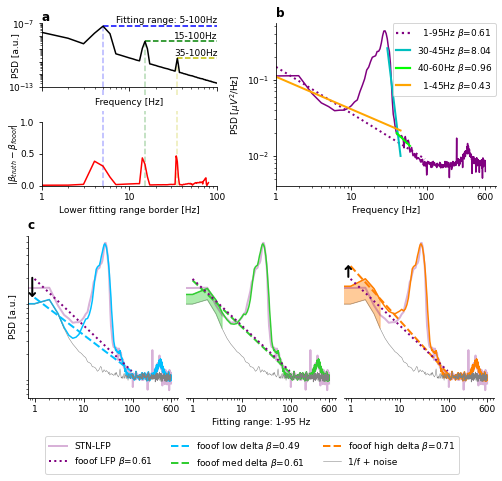

In [21]:
# Prepare Gridspec
fig = plt.figure(figsize=[fig_width, 6.5], constrained_layout=True)

gs0 = gridspec.GridSpec(3, 1, figure=fig, height_ratios=[6, 6, 1])

# a) and b)
gs00 = gridspec.GridSpecFromSubplotSpec(2, 2,
                                        subplot_spec=gs0[0],
                                        width_ratios=[8, 10])
ax1 = fig.add_subplot(gs00[0, 0])
ax2 = fig.add_subplot(gs00[1, 0])
ax3 = fig.add_subplot(gs00[:, 1])

# c)
gs01 = gs0[1].subgridspec(1, 3)
ax4 = fig.add_subplot(gs01[0])
ax5 = fig.add_subplot(gs01[1])
ax6 = fig.add_subplot(gs01[2])

c_axes = [ax4, ax5, ax6]

# Legend suplot
gs02 = gs0[2]
ax_leg = fig.add_subplot(gs02)
ax_leg.axis("off")

# a)
ax = ax1  # a1
ax.loglog(freq_a, full_psd, c_sim)  # Plot sim

# Annotate fitting ranges
vline_dic = dict(ls="--", clip_on=False, alpha=0.3)
ymin = ylim_a1[0] / 4
for i, (freq_low, color) in enumerate(zip(freqs123, colors123)):
    y = full_psd[freq_low]
    xmin = freq_low
    xmax = upper_fitting_border
    h_coords = (y, xmin, xmax)
    ax.hlines(*h_coords, color=color, ls="--")
    v_coords = (xmin, ymin, y)
    ax.vlines(*v_coords, color=color, **vline_dic)

    # Add annotation
    s = f"{freq_low}-{xmax}Hz"
    if i == 0:
        s = "Fitting range: " + s
        y = y**.97
    else:
        y = y**.98
    ax.text(s=s, y=y, **text_dic)

# Set axes
ax.text(s="a", **abc, transform=ax.transAxes)
ax.set(**axes_a1)
ax.set_ylabel(ylabel_a1, labelpad=-12)
y_minor = mpl.ticker.LogLocator(subs=np.arange(0, 1, .1), numticks=10)
ax.yaxis.set_minor_locator(y_minor)
ax.set_yticklabels([], minor=True)

# a2
ax = ax2
ax.semilogx(*error_plot)  # Plot error

# Annotate fitting ranges
for i, (freq_low, color) in enumerate(zip(freqs123, colors123)):
    xmin = freq_low
    ymin = 0
    ymax = 1.18
    v_coords = (xmin, ymin, ymax)
    ax.vlines(*v_coords, color=color, **vline_dic)

# Set axes
ax.set(**axes_a2)
ax.set_ylabel(ylabel_a2, labelpad=0)

# b)
ax = ax3
ax.loglog(*plot_psd_spec10)  # Plot spectrum

# Plot fooof fits
for fit_range in fit_ranges:
    ax.loglog(*fit_range[0], **fit_range[1])

# Set axes
ax.set(**axes_b)

# decrease legend handle linewidth
leg = ax.legend(handlelength=1.5, borderaxespad=0)
for handle in leg.legendHandles:
    handle.set_linewidth(2.2)
ax.text(s="b", **abc, transform=ax.transAxes)


# c)

# Use "None" to make sure we have just one label for each repetitive plot
spec10_label = ["STN-LFP", None, None]
spec10_fit_label = [rf"fooof LFP $\beta$={exp_LFP:.2f}", None, None]
aperiodic_label = [None, None, "1/f + noise"]

arrows = [arr_pos_low, None, arr_pos_high]

for i, ax in enumerate(c_axes):
    # Plot LFP and fooof fit
    ax.loglog(*plot_psd_spec10_adj, alpha=.3, **spec10_kwargs,
              label=spec10_label[i])
    ax.loglog(*plot_fit_spec10, alpha=1, zorder=5, **spec10_kwargs,
              label=spec10_fit_label[i])

    # Plot sim low delta power and fooof fit
    ax.loglog(*psd_delta_vary[i])
    ax.loglog(*psd_delta_fits[i], **delta_kwargs[i], label=delta_labels[i])

    # Plot aperiodic component of sim
    ax.loglog(*plot_aperiodic, **aperiodic_kwargs, label=aperiodic_label[i])

    # Indicate delta power as fill between ap. component and full spectrum
    ax.fill_between(*delta_power[i], color=colors_c[i], **delta_fill_dic)

    # Draw arrow
    if i != 1:
        ax.annotate(**arrows[i])
    else:
        ax.set_xlabel(x_label_c2)

    # Save legend handles labels and set axes
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        ax.set_ylabel(ylabel_c, labelpad=5)
        ax.text(s="c", **abc, transform=ax.transAxes)
    else:
        hands, labs = ax.get_legend_handles_labels()
        handles.extend(hands)
        labels.extend(labs)
        ax.spines["left"].set_visible(False)
        ax.set_yticks([], minor=True)
    ax.set(**axes_c)

# Set legend between subplots
leg = ax_leg.legend(handles, labels, **leg_c)

plt.savefig(fig_path + "Fig3.pdf", bbox_inches="tight")
plt.savefig(fig_path + "Fig3.png", dpi=1000, bbox_inches="tight")
plt.show()

# Supplementary figure showing the fooof fits of 3 b)

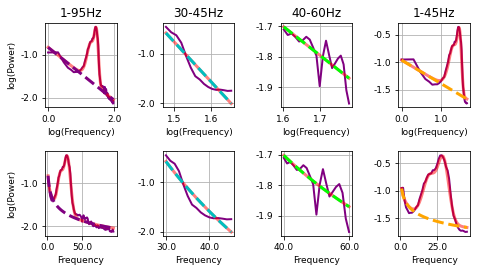

In [8]:
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(2, 4, figsize=[fig_width, 4])
for i in range(4):
    ax = axes[0, i]
    kwargs = dict(add_legend=False,
                  aperiodic_kwargs=dict(color=fit_params[i][2], alpha=1),
                  data_kwargs=dict(color=c_real))
    title = f"{fit_params[i][0][0]}-{fit_params[i][0][1]}Hz"
    fooof_fits[i].plot(ax=ax, plt_log=True, **kwargs)
    ax.set_title(title, fontsize=panel_fontsize)
    xlabel = ax.get_xlabel()
    ylabel = ax.get_ylabel()
    xticks = np.round(ax.get_xticks(), 1)
    yticks = np.round(ax.get_yticks(), 1)
    ax.set_xticklabels(xticks, fontsize=legend_fontsize)
    ax.set_yticklabels(yticks, fontsize=legend_fontsize)
    ax.set_xlabel(xlabel, fontsize=legend_fontsize)
    ax.set_ylabel(ylabel, fontsize=legend_fontsize)
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)
    if i > 0:
        ax.set_ylabel("")

    ax = axes[1, i]
    fooof_fits[i].plot(ax=ax, plt_log=False, **kwargs)
    if i > 0:
        ax.set_ylabel("")
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)
    xlabel = ax.get_xlabel()
    ylabel = ax.get_ylabel()
    xticks = np.round(ax.get_xticks(), 1)
    yticks = np.round(ax.get_yticks(), 1)
    ax.set_xticklabels(xticks, fontsize=legend_fontsize)
    ax.set_yticklabels(yticks, fontsize=legend_fontsize)
    ax.set_xlabel(xlabel, fontsize=legend_fontsize)
    ax.set_ylabel(ylabel, fontsize=legend_fontsize)
plt.tight_layout()
plt.savefig(fig_path + "Fig3_SuppB.png", dpi=1000, bbox_inches="tight")
plt.savefig(fig_path + "Fig3_SuppB.pdf", bbox_inches="tight")
plt.show()



# Supplementary figure of figure 3 c) showing the correlation between delta power and the y-intercept

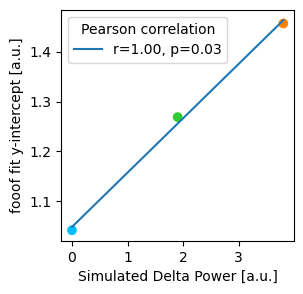

In [10]:
mpl.rcParams.update(mpl.rcParamsDefault)

y_intercepts = [fm_low.aperiodic_params_[0],
                fm_med.aperiodic_params_[0],
                fm_high.aperiodic_params_[0]]

delta_power = [low_delta[1], med_delta[1], high_delta[1]]

# Pearson
r_corr, p_val = pearsonr(delta_power, y_intercepts)

# Regression
m, b = np.polyfit(delta_power, y_intercepts, 1)

# Plot
fig, ax = plt.subplots(1, 1, figsize=[3, 3])
ax.scatter(delta_power, y_intercepts, c=[c_low, c_med, c_high])
ax.plot(delta_power, m*np.array(delta_power) + b,
        label=f"r={r_corr:.2f}, p={p_val:.2f}")
ax.set(xlabel="Simulated Delta Power [a.u.]",
       ylabel="fooof fit y-intercept [a.u.]")
ax.legend(title="Pearson correlation")
plt.savefig(fig_path + "Fig3_SuppC.png", dpi=1000, bbox_inches="tight")
plt.savefig(fig_path + "Fig3_SuppC.pdf", bbox_inches="tight")
plt.show()